In [2]:
from scipy.optimize import fsolve
import numpy as np

# Define the function to solve tan(w) = 2λw / (λ^2 w^2 - 1)
def equation_to_solve(w, lam):
    return np.tan(w) - 2 * lam * w / (lam**2 * w**2 - 1)

# A reasonable starting guess for w_n solutions could be around the zeros of the tan function, which are at (n+0.5)*pi
# We will use lambda = 1 (for example) and find the first few solutions
lambda_value = 1
solutions = []
number_of_solutions = 100

# We'll start the initial guesses just above the zero points of the tangent function to avoid division by zero
initial_guesses = [(n + 0.5) * np.pi for n in range(number_of_solutions)]

# Using fsolve to find the solutions
for guess in initial_guesses:
    wn_solution = fsolve(equation_to_solve, guess, args=(lambda_value))
    # We only append the solution if it is not already in the list (to avoid duplicates due to numerical precision)
    if not any(np.isclose(wn_solution, sol) for sol in solutions):
        solutions.append(wn_solution[0])

number_of_solutions = len(solutions)


In [3]:
# Given the solutions w, we now want to calculate the corresponding theta_n and b_n(x)
# Let's define the functions to calculate theta_n and b_n(x) for lambda_value = 1
# Based on the paper's formulas:
# theta_n^1D = 2 * lambda / (lambda^2 * w_n^2 + 1)
# b_n^1D(x) = A_n * sin(w_n * x) + A_n * lambda * cos(w_n * x)

# Function to calculate theta_n
def theta_n_1D(w_n, lam):
    return 2 * lam / ((lam**2)*(w_n**2) + 1) 

# Function to calculate b_n(x)
def b_n_1D(w_n, lam, x): 
    A_n =np.sqrt((np.sin(w_n * x))**2 + (lam*w_n*np.cos(w_n * x))**2)
    return  (np.sin(w_n * x) + lam * w_n * np.cos(w_n * x)) / A_n

# Calculate theta_n and b_n for a range of x values
# Choose an arbitrary range for x, for example, 0 to 2*pi with 100 points
mesh_size = 100
x_values = np.linspace(0, 1, mesh_size)

# Calculate theta_n for each solution w
theta_values_1D = np.array([theta_n_1D(w, lambda_value) for w in solutions])

# Calculate b_n for each combination of w_n and x_values
b_values_1D = np.array([[b_n_1D(w, lambda_value, x) for x in x_values] for w in solutions])

# The result will be a list of theta values and a 2D-array of b_n values across the x range
#theta_values, b_values.shape
theta_values_1D.shape



(100,)

In [4]:
b_values_1D.shape

(100, 100)

In [5]:
# For the 2D case, we have the formulas from the paper:
# theta_n^2D = theta_i^1D * theta_j^1D
# b_n^2D(x) = b_i^1D(x1) * b_j^1D(x2)

# We will calculate the 2D eigenvalues and eigenfunctions using the outer product

# Calculate theta_n^2D using outer product to find all combinations of theta_i and theta_j
theta_values_2D = np.outer(theta_values_1D, theta_values_1D)

# Calculate b_n^2D using outer product for the eigenfunctions
# Since we have 100 x values and 5 solutions, there will be 25 combinations in total for b_n^2D
b_values_2D = np.array([np.outer(b_values_1D[i], b_values_1D[j]) for i in range(len(solutions)) for j in range(len(solutions))])

# The result will be a matrix of theta values and a list of matrices for b_n values
theta_values_2D.shape, b_values_2D.shape


((100, 100), (10000, 100, 100))

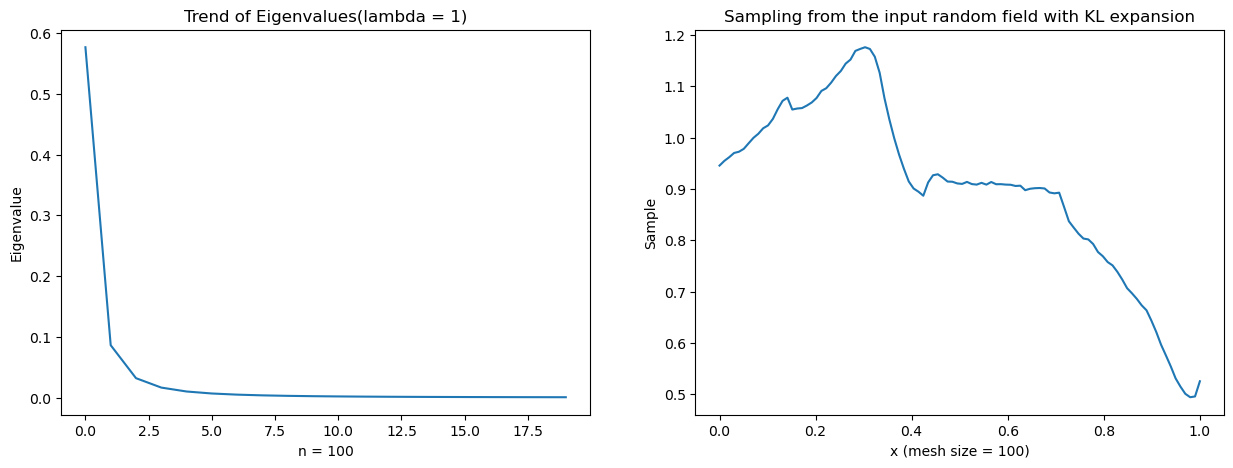

In [6]:
#1D
import matplotlib.pyplot as plt
#assume the expectation of Z is 0
mean = 0

xi_n = np.random.normal(size=number_of_solutions)
n_list = np.arange(0,number_of_solutions)
Z = mean + np.dot((xi_n * theta_values_1D).T,b_values_1D)


fig, ax = plt.subplots(1,2,figsize = (15,5))

ax[0].plot(n_list[:20],theta_values_1D[:20])
ax[0].set_xlabel(f'n = {number_of_solutions}')
ax[0].set_ylabel('Eigenvalue')
ax[0].set_title(f'Trend of Eigenvalues(lambda = {lambda_value})')

ax[1].plot(x_values,Z)
ax[1].set_xlabel(f'x (mesh size = {mesh_size})')
ax[1].set_ylabel('Sample')
ax[1].set_title('Sampling from the input random field with KL expansion')

plt.show()



In [7]:
print(b_values_2D[1].shape)

(100, 100)


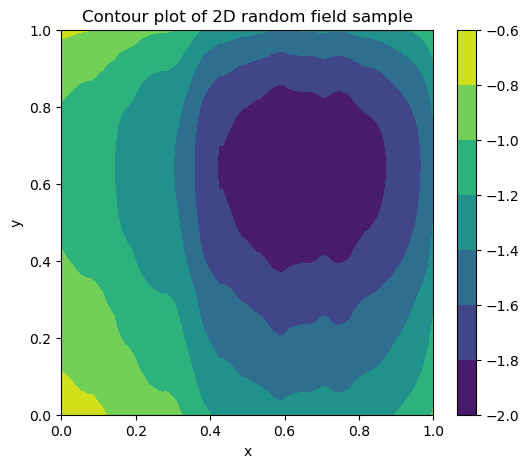

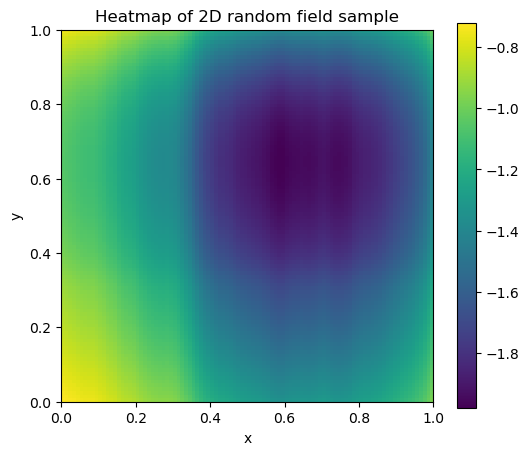

In [11]:
#2D
mean = np.zeros((mesh_size,mesh_size))
xi_n = np.random.normal(size=number_of_solutions^2)
theta_values_flat = theta_values_2D.flatten()
Z_2D = mean

for i in range(number_of_solutions^2):
  Z_2D += xi_n[i]*theta_values_flat[i]*b_values_2D[i]


x = np.linspace(0, 1, mesh_size)
y = np.linspace(0, 1, mesh_size)
X, Y = np.meshgrid(x, y)

plt.figure(figsize=(6, 5))
cp = plt.contourf(X, Y, Z_2D, cmap='viridis')
plt.colorbar(cp) 
plt.title('Contour plot of 2D random field sample')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure(figsize=(6, 5))
plt.imshow(Z_2D, cmap='viridis', extent=[0, 1, 0, 1], origin='lower')
plt.colorbar() 
plt.title('Heatmap of 2D random field sample')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
